## Objetivo

El objetivo de este trabajo es entrenar un modelo de Machine Learning que permita predecir fallos en maquinas industriales a partir de datos de sensores y condiciones de operacion. Se trabajara el problema como un problema de clasificacion binaria, donde se buscara predecir si una maquina fallara o no en un futuro cercano.

## Analisis exploratorio de datos (EDA)

El dataset a utilizar esta formado por infromacion provenientes de sensores y otras variables que describen las condiciones de operacion de diferentes maquinas y columnas que indican el fallo de ciertos componentes de las mismas como tambien fallos generales. 

Dado a que los datos de mantenimiento predictivo suelen ser dificiles de obtener ya que las empresas no suelen compartirlos, se utilizara un dataset sintetico explicado en [Explainable Artificial Intelligence for Predictive Maintenance Applications](https://www.semanticscholar.org/paper/Explainable-Artificial-Intelligence-for-Predictive-Matzka/b609c8e9ec6a2b8c642810953ef6dffe5766f7c1) que se puede descargar de forma gratuita del siguiente [enlace](https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset).

### Columnas del dataset

El conjunto de datos consta de 10,000 puntos de datos almacenados como filas con 14 características en columnas: 
- **UID**: identificador único que varía de 1 a 10,000 
- **product ID**: compuesto por una letra L, M o H para variantes de calidad de producto baja (60% de todos los productos), media (30%) y alta (10%), y un número de serie específico de la variante 
- **Type**: tipo de máquina, con 3 tipos diferentes L, M y H
- **air temperature [K]**: generada utilizando un proceso de caminata aleatoria, normalizada posteriormente a una desviación estándar de 2 K alrededor de 300 K  
- **process temperature [K]**: generada utilizando un proceso de caminata aleatoria normalizada a una desviación estándar de 1 K, añadida a la temperatura del aire más 10 K  
- **rotational speed [rpm]**: calculada a partir de una potencia de 2860 W, superpuesta con un ruido distribuido normalmente  
- **torque [Nm]**: valores de torque distribuidos normalmente alrededor de 40 Nm con una σ = 10 Nm y sin valores negativos  
- **tool wear [min]**: las variantes de calidad H/M/L añaden 5/3/2 minutos de desgaste a la herramienta utilizada en el proceso  
- **machine failure**: indica si la máquina ha fallado bajo las condiciones indicadas por los campos anteriores, si alguno de los modos de fallo es verdadero.  

Modos de fallo:
- **TWF**: fallo de desgaste de la herramienta, si el desgaste de la herramienta supera un umbral de 50 minutos  
- **HDF**: fallo de desgaste de la herramienta, si el desgaste de la herramienta supera un umbral de 100 minutos  
- **PWF**: fallo de la herramienta de proceso, si la temperatura del proceso supera un umbral de 350 K  
- **OSF**: fallo de sobrecalentamiento, si la temperatura del aire supera un umbral de 350 K  
- **RNF**: fallo de velocidad de rotación, si la velocidad de rotación supera un umbral de 3000 rpm


In [43]:
import pandas as pd
from matplotlib import pyplot as plt

In [44]:
dataset = pd.read_csv('ai4i+2020+predictive+maintenance+dataset/ai4i2020.csv')
dataset.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


A priori vamos a descartar la columna **UDI** ya que, al ser un identificador único por fila, no aporta información relevante para el modelo. A modo de target, utilizaremos la columna **machine failure** que indica el fallo de la maquina y descartamos las columnas de los modos de fallo para trabajar el problema como una clasificación binaria.

In [45]:
to_drop = ['UDI', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

dataset = dataset.drop(columns=to_drop)
dataset.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M14860,M,298.1,308.6,1551,42.8,0,0
1,L47181,L,298.2,308.7,1408,46.3,3,0
2,L47182,L,298.1,308.5,1498,49.4,5,0
3,L47183,L,298.2,308.6,1433,39.5,7,0
4,L47184,L,298.2,308.7,1408,40.0,9,0


In [46]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 625.1+ KB


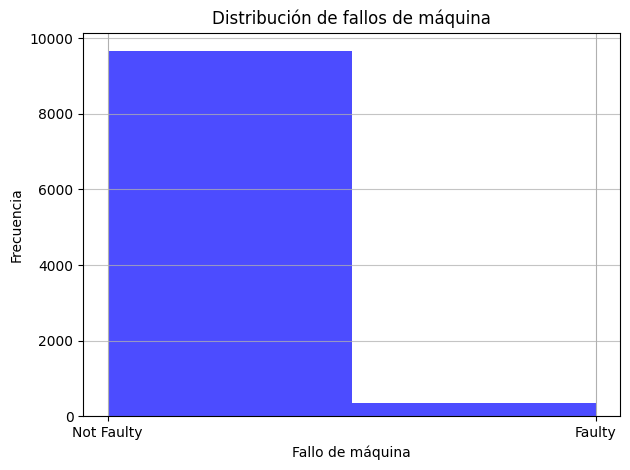

In [47]:
dataset['Machine failure'].hist(bins=2, color='blue', alpha=0.7)
plt.title('Distribución de fallos de máquina')
plt.xlabel('Fallo de máquina')
plt.ylabel('Frecuencia')
plt.xticks([0, 1], ['Not Faulty', 'Faulty'])
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

Vemos que se presenta un desbalance muy fuerte en el target, lo cual es de esperar en un problema de mantenimiento predictivo, ya que las fallas son eventos poco frecuentes. Esto puede afectar el rendimiento del modelo, por lo que se deben considerar técnicas para manejar el desbalance, como el sobremuestreo de la clase minoritaria o el submuestreo de la clase mayoritaria.


### Analisis de variables categoricas

In [48]:
unique = dataset['Product ID'].nunique()
print(f'Proporcion de Product Ids unicos: {unique / len(dataset)}')


Proporcion de Product Ids unicos: 1.0


Tipos de máquina:
Type
L    0.6000
M    0.2997
H    0.1003
Name: count, dtype: float64


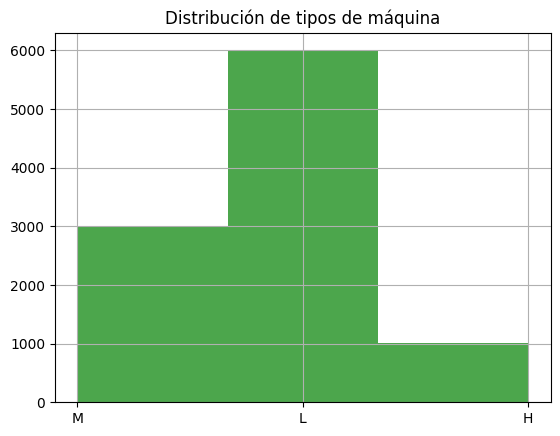

In [49]:
n_counts = dataset['Type'].value_counts()
print('Tipos de máquina:')
print(f'{n_counts / len(dataset)}')

dataset['Type'].hist(bins=3, color='green', alpha=0.7)
plt.title('Distribución de tipos de máquina')
plt.show()

Vemos que el **Product ID** es unico para cada fila, por lo que no aporta información relevante para el modelo. Por otro lado, la columna **Type** tiene 3 tipos diferentes de maquinas (L, M y H) con una distribución de 60%, 30% y 10% respectivamente. Esto puede ser relevante para el modelo ya que las diferentes maquinas pueden tener diferentes comportamientos y fallos. Descartamos la columna **Product ID**.

In [50]:
dataset.drop(columns=['Product ID'], inplace=True)

Como la variable **Type** presenta una cardinalidad baja vamos a aplicar One Hot Encoding para codificar cada una de las 3 categorias en una columna binaria.


In [51]:
dataset = pd.get_dummies(dataset, columns=['Type'], drop_first=True)
dataset.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,True,False
2,298.1,308.5,1498,49.4,5,0,True,False
3,298.2,308.6,1433,39.5,7,0,True,False
4,298.2,308.7,1408,40.0,9,0,True,False
